In [1]:
%env LLM_API_KEY=替换为自己的key
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1

env: LLM_API_KEY=替换为自己的key
env: LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1


In [2]:
import chromadb
import langchain
import langchain_community
import langchain_core
import pypdf
import sentence_transformers

for module in (langchain, langchain_core, langchain_community, pypdf, sentence_transformers, chromadb):
    print(f"{module.__name__:<30}{module.__version__}")

/opt/anaconda3/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


langchain                     0.2.10
langchain_core                0.2.28
langchain_community           0.2.9
pypdf                         4.3.1
sentence_transformers         3.0.1
chromadb                      0.5.4


In [3]:
import os
import pandas as pd

In [4]:
expr_version = 'retrieval_v8_step_back_prompting'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

# 读取文档

In [5]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 文档切分

In [6]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [7]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 检索

In [8]:
from langchain_openai import ChatOpenAI

# llm = ChatOllama(base_url='http://localhost:11434', model='qwen2:7b-instruct')
# 使用Ollama，注意，不要使用上面这行，直接使用ChatOllama类后续流程会报错
llm = ChatOpenAI(
    model='qwen2:7b-instruct', 
    base_url='http://localhost:11434/v1', 
    api_key='ollama'
)

In [9]:
llm('你是谁')

/opt/anaconda3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


AIMessage(content='我是通义千问，是由阿里云开发的一个AI助手。我被设计用来回答各种问题、提供信息和与用户进行对话。有什么特定的问题或主题你想要了解更多吗？我会尽力帮助你。', response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 10, 'total_tokens': 56}, 'model_name': 'qwen2:7b-instruct', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'stop', 'logprobs': None}, id='run-e6e537a1-151d-41c7-984b-2cc4f07ed1cf-0', usage_metadata={'input_tokens': 10, 'output_tokens': 46, 'total_tokens': 56})

下面这段是官方示例

In [10]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

system = """You are an expert at taking a specific question and extracting a more generic question that gets at \
the underlying principles needed to answer the specific question.

You will be asked about a set of software for building LLM-powered applications called LangChain, LangGraph, LangServe, and LangSmith.

LangChain is a Python framework that provides a large set of integrations that can easily be composed to build LLM applications.
LangGraph is a Python package built on top of LangChain that makes it easy to build stateful, multi-actor LLM applications.
LangServe is a Python package built on top of LangChain that makes it easy to deploy a LangChain application as a REST API.
LangSmith is a platform that makes it easy to trace and test LLM applications.

Given a specific user question about one or more of these products, write a more generic question that needs to be answered in order to answer the specific question. \

If you don't recognize a word or acronym to not try to rewrite it.

Write concise questions."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
# llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
step_back = prompt | llm | StrOutputParser()

In [11]:
prompt.invoke({'question': '美国单一家庭房贷整体拖欠率在2023年二季度达到多少？'})

ChatPromptValue(messages=[SystemMessage(content="You are an expert at taking a specific question and extracting a more generic question that gets at the underlying principles needed to answer the specific question.\n\nYou will be asked about a set of software for building LLM-powered applications called LangChain, LangGraph, LangServe, and LangSmith.\n\nLangChain is a Python framework that provides a large set of integrations that can easily be composed to build LLM applications.\nLangGraph is a Python package built on top of LangChain that makes it easy to build stateful, multi-actor LLM applications.\nLangServe is a Python package built on top of LangChain that makes it easy to deploy a LangChain application as a REST API.\nLangSmith is a platform that makes it easy to trace and test LLM applications.\n\nGiven a specific user question about one or more of these products, write a more generic question that needs to be answered in order to answer the specific question. \nIf you don't r

In [12]:
step_back.invoke({'question': '美国单一家庭房贷整体拖欠率在2023年二季度达到多少？'})

'2023年第二季度全美单户家庭的抵押贷款拖欠率是多少?'

## 准备Step back prompt

可以使用官方的chain，也可以自己定义prompt，此处为了讲清楚原理，使用自定义的chain

In [13]:
from langchain.prompts import FewShotChatMessagePromptTemplate, ChatPromptTemplate

examples = [
    {
        "input": "美联储预计下半年利率会下调多少？",
        "output": "美联储下半年的利率政策会如何制定",
    },
    {
        "input": "如何评估一家公司股票的内在价值？",
        "output": "什么方法可以用来评估资产的真实价值？",
    }
]
# 转换为消息
example_prompt = ChatPromptTemplate.from_messages(
    [
        ('human', '{input}'),
        ('ai', '{output}')
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples
)
prompt = ChatPromptTemplate.from_messages([
    (
        'system',
        """你是金融领域的专家。你的任务是把一个问题改写成一个更一般或更抽象的问题，但注意仅问题改写得更一般即可，如果问题有主体，问题的主体要保持不变。如果你不确定如何改写，请保持原问题不变。直接输出改写后的问题即可，不需要包含“改写之后的问题”之类的描述性内容。这里有几个例子:"""
    ),
    few_shot_prompt,
    ('user', '{question}')
])

## 准备用于生成更抽象问题的Chain

In [14]:
step_back_query_gen = (
    prompt
    | llm
    | (lambda ai_msg: ai_msg.content)
    | (lambda x: x.replace('AI:', '').replace('ai:', '').strip() if x.lower().startswith('ai:') else x)
)

In [15]:
step_back_query_gen.invoke({'question': '美国单一家庭房贷整体拖欠率在2023年二季度达到多少？'})

'什么是影响个人贷款违约率的主要因素？'

## 准备检索器

In [16]:
import shutil
import torch

from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma

# 可以替换为本地模型地址
model_path = 'BAAI/bge-large-zh-v1.5'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings


def get_vector_db(embeddings, docs, db_name):
    persist_directory = os.path.join(expr_dir, 'chroma', db_name)
    shutil.rmtree(persist_directory, ignore_errors=True)

    vector_db = Chroma.from_documents(
        splitted_docs,
        embedding=embeddings,
        persist_directory=persist_directory
    )
    return vector_db

device: cuda


In [17]:
vector_db = get_vector_db(get_embeddings(model_path), splitted_docs, 'step_back')

def get_retrieve_chain(top_k):
    chain = (
        step_back_query_gen
        | (lambda x: vector_db.similarity_search(x, k=top_k))
    )
    return chain

测试一下

In [18]:
retrieve_chain = get_retrieve_chain(3)

In [19]:
retrieve_chain.invoke('报告的发布机构是什么？')

[Document(metadata={'page': 33, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': '3e312dfa-dd43-4ab9-961f-a2e442c89cdd'}, page_content='全球经济金融展望报告\n中国银行研究院 32 2024年\n图19：美国联邦基金目标利率与全球MSCI指数\n资料来源：Wind，中国银行研究院\n表3：全球主要股指概览\n注：涨跌幅区间为2023年1月1日至2023年11月15日，收盘价和市盈\n率为2023年11月15日。\n资料来源：Wind，中国银行研究院'),
 Document(metadata={'page': 51, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': 'ebf0d999-59f6-4fd3-941e-05a7a60c255a'}, page_content='免责声明\n本研究报告由中国银行研究院撰写，研究报告中所引用信息均来自公开资料。\n本研究报告中包含的观点或估计仅代表作者迄今为止的判断，它们不一定反映中国银行的观点。中国\n银行研究院可以不经通知加以改变，且没有对此报告更新、修正或修改的责任。\n本研究报告内容及观点仅供参考，不构成任何投资建议。对于本报告所提供信息所导致的任何直接的\n或者间接的投资盈亏后果不承担任何责任。\n本研究报告版权仅为中国银行研究院所有，未经书面许可，任何机构和个人不得以任何形式翻版、复\n制和发布。如引用发布，需注明出处为中国银行研究院，且不得对本报告进行有悖原意的引用、删节和修\n改。中国银行研究院保留对任何侵权行为和有悖报告原意的引用行为进行追究的权利。'),
 Document(metadata={'page': 0, 'source': 'data/2024全球经济金融展望报告.pdf', 'uuid': 'e73a0c9d-d42b-4350-a4c3-b38bf67c68a5'}, page_content='研究院\n全球经济金融展望报告\n要点2024年年报（总第57期） 报告日期：2023年12月12日\n●2023年全球经济增长动力持续回落，各国复苏分化，\n发达经济体增速明显放缓，新兴经济体整体表现稳定。\n全球贸易增长乏力，

## 检索性能对比

In [20]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

### 不使用Step Back Prompting

In [21]:
from tqdm.auto import tqdm

def get_hit_stat_df(top_k_arr=list(range(1, 9))):
    hit_stat_data = []
    pbar = tqdm(total=len(top_k_arr) * len(test_df))
    for k in top_k_arr:
        pbar.set_description(f'k={k}')

        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']

            chunks = vector_db.similarity_search(question, k=k)
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]
            assert len(chunks) <= k

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
            pbar.update(1)
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [22]:
orig_query_hit_stat_df = get_hit_stat_df()
orig_query_hit_stat_df['step_back_prompting'] = 'w/o'

  0%|          | 0/744 [00:00<?, ?it/s]

### 使用Step Back Prompting

In [23]:
def get_step_back_hit_stat_df(top_k_arr=list(range(1, 9))):
    hit_stat_data = []
    pbar = tqdm(total=len(top_k_arr) * len(test_df))
    for k in top_k_arr:
        pbar.set_description(f'k={k}')

        step_back_retrieve_chain = get_retrieve_chain(k)
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            
            chunks = step_back_retrieve_chain.invoke(question)
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]
            
            assert len(chunks) <= k

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
            pbar.update(1)
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [24]:
step_back_hit_stat_df = get_step_back_hit_stat_df()
step_back_hit_stat_df['step_back_prompting'] = 'w/'

  0%|          | 0/744 [00:00<?, ?it/s]

### 对比

In [25]:
hit_stat_df = pd.concat([orig_query_hit_stat_df, step_back_hit_stat_df])

In [26]:
hit_stat_df.groupby(['step_back_prompting', 'top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,step_back_prompting,top_k,hit_rate
0,w/,1,0.301075
1,w/,2,0.505376
2,w/,3,0.526882
3,w/,4,0.645161
4,w/,5,0.655914
5,w/,6,0.741935
6,w/,7,0.720430
7,w/,8,0.784946
8,w/o,1,0.462366
9,w/o,2,0.591398


<Axes: xlabel='top_k', ylabel='hit'>

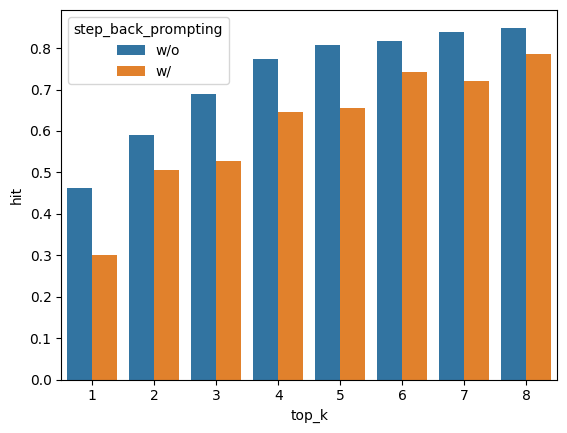

In [27]:
import seaborn as sns

sns.barplot(x='top_k', y='hit', hue='step_back_prompting', data=hit_stat_df, errorbar=None)

# 预测

In [28]:
from langchain.llms import Ollama

ollama_llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434'
)

In [32]:
def rag(question, n_chunks=3):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{question}}
请回答：
""".strip()

    step_back_retrieve_chain = get_retrieve_chain(n_chunks)
    chunks = step_back_retrieve_chain.invoke(question)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{question}}', question)

    return ollama_llm(prompt), chunks

In [33]:
print(rag('2023年10月美国ISM制造业PMI指数较上月有何变化？')[0])

/opt/anaconda3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


2023年10月美国ISM制造业PMI指数为50.4%，较前一个月的55.5%明显回落。


In [34]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(prediction_df, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [35]:
pred_df = predict(prediction_df, n_chunks=3)

  0%|          | 0/100 [00:00<?, ?it/s]

# 评估

In [36]:
from langchain_openai import ChatOpenAI

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

import time

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        result = judge_llm.invoke(prompt).content
        results.append(result)

        time.sleep(1)
    return results

In [37]:
pred_df['raw_score'] = evaluate(pred_df)

  0%|          | 0/100 [00:00<?, ?it/s]

In [38]:
pred_df['raw_score'].unique()

array(['是', '否'], dtype=object)

In [39]:
pred_df['score'] = (pred_df['raw_score'] == '是').astype(int)

In [40]:
pred_df['score'].mean()

0.56